In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import math 
import sys
import statistics as stats

In [99]:
movie_budgets_clean= pd.read_csv('movie_budgets_clean.csv')

In [100]:
movie_budgets_clean['budget_gross_diff'] = movie_budgets_clean['worldwide_gross'] - movie_budgets_clean['production_budget']
movie_budgets_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747


In [101]:
movie_budgets_clean['roi'] = (movie_budgets_clean['worldwide_gross'] / movie_budgets_clean['production_budget'] ) -1

In [102]:
movie_budgets_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696


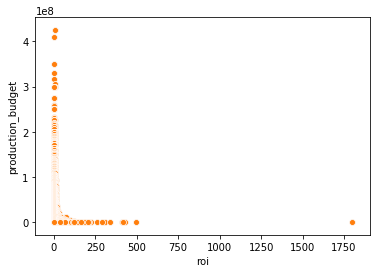

In [103]:
sns.scatterplot(x = movie_budgets_clean['roi'], y= movie_budgets_clean['production_budget']);
sorted_list = movie_budgets_clean.sort_values(by= ['roi'] , ascending=False)

x = pd.Series(np.random.normal(size= 5782)) # 200 values
x = x[x.between(x.quantile(.15), x.quantile(.85))]

sns.distplot(x);

sns.scatterplot(x= movie_budgets_clean['roi'], y= movie_budgets_clean['production_budget']);

In [104]:
movie_budgets_clean.describe()

,id,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
count,5234.000000,5.234000e+03,5.234000e+03,5.234000e+03,5.234000e+03,5234.000000
mean,50.346580,3.403348e+07,4.625747e+07,1.007615e+08,6.672803e+07,4.267876
std,28.848667,4.296048e+07,7.029651e+07,1.811226e+08,1.518522e+08,30.997659
min,1.000000,1.100000e+03,3.880000e+02,4.010000e+02,-2.002376e+08,-0.999875
25%,25.000000,6.500000e+06,4.289718e+06,8.142571e+06,-1.396634e+06,-0.241161
50%,50.000000,2.000000e+07,2.198422e+07,3.543844e+07,1.357260e+07,0.961653
75%,75.000000,4.500000e+07,5.756598e+07,1.093357e+08,7.088258e+07,3.059457
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2.351345e+09,1799.000000


In [105]:
movie_budgets_outliers = movie_budgets_clean[movie_budgets_clean['roi'] < 0.961653 + (2*30.997659)] 


In [106]:
movie_budgets_outliers = movie_budgets_clean[movie_budgets_clean['worldwide_gross'] < 3.543844e+07+(2*1.811226e+08) ]

In [107]:
movie_budgets_outliers = movie_budgets_clean[movie_budgets_clean['production_budget'] > 100000000]

In [108]:
Date_split = movie_budgets_outliers.release_date.str.split(" ",expand=True)

In [109]:
seasonlity_analysis = pd.concat([Date_split, movie_budgets_outliers], axis=1)
seasonlity_analysis

,0,1,2,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
0,Dec,"18,",2009,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577
1,May,"20,",2011,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673
2,Jun,"7,",2019,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108
3,May,"1,",2015,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841
4,Dec,"15,",2017,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696
...,...,...,...,...,...,...,...,...,...,...,...
357,Jul,"1,",2009,59,"Jul 1, 2009",Public Enemies,102500000,97104620,212282709,109782709,1.071051
358,Nov,"17,",2006,60,"Nov 17, 2006",Casino Royale,102000000,167365000,594420283,492420283,4.827650
359,Jun,"21,",2002,61,"Jun 21, 2002",Minority Report,102000000,132024714,358824714,256824714,2.517889
360,Dec,"21,",2018,62,"Dec 21, 2018",Bumblebee,102000000,127195589,465195589,363195589,3.560741


In [110]:
seasonlity_analysis = seasonlity_analysis.rename(columns={ 0 : 'month', 1: 'day', 2: 'year'})

In [111]:
seasonlity_analysis

,month,day,year,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
0,Dec,"18,",2009,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577
1,May,"20,",2011,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673
2,Jun,"7,",2019,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108
3,May,"1,",2015,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841
4,Dec,"15,",2017,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696
...,...,...,...,...,...,...,...,...,...,...,...
357,Jul,"1,",2009,59,"Jul 1, 2009",Public Enemies,102500000,97104620,212282709,109782709,1.071051
358,Nov,"17,",2006,60,"Nov 17, 2006",Casino Royale,102000000,167365000,594420283,492420283,4.827650
359,Jun,"21,",2002,61,"Jun 21, 2002",Minority Report,102000000,132024714,358824714,256824714,2.517889
360,Dec,"21,",2018,62,"Dec 21, 2018",Bumblebee,102000000,127195589,465195589,363195589,3.560741


In [112]:
monthdict = { 'Jan' : 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, "May": 5, "Jun": 6,
         'Jul' : 7, 'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}
                           
seasonlity_analysis = seasonlity_analysis.replace({'month': monthdict})                         

In [113]:
seasonlity_analysis = seasonlity_analysis.sort_values('month')

In [114]:
seasonlity_analysis.head(50)

,month,day,year,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
209,1,"29,",2016,11,"Jan 29, 2016",Kung Fu Panda 3,140000000,143528619,517599142,377599142,2.697137
327,1,"14,",2011,29,"Jan 14, 2011",The Green Hornet,110000000,98780042,229155503,119155503,1.083232
279,1,"13,",2017,81,"Jan 13, 2017",Monster Trucks,125000000,33370166,61642798,-63357202,-0.506858
307,2,"7,",1997,9,"Feb 7, 1997",Dante's Peak,115000000,67163857,178200000,63200000,0.549565
254,2,"22,",2019,56,"Feb 22, 2019",How to Train Your Dragon: The Hidden World,129000000,160791800,519258283,390258283,3.025258
41,2,"16,",2018,42,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1148258224,5.741291
294,2,"12,",2014,96,"Feb 12, 2014",RoboCop,120000000,58607007,242981799,122981799,1.024848
123,2,"14,",2019,24,"Feb 14, 2019",Alita: Battle Angel,170000000,85710210,402976036,232976036,1.370447
190,2,"12,",2010,91,"Feb 12, 2010",The Wolfman,150000000,62189884,142634358,-7365642,-0.049104
191,2,"17,",2017,92,"Feb 17, 2017",The Great Wall,150000000,45157105,334486852,184486852,1.229912


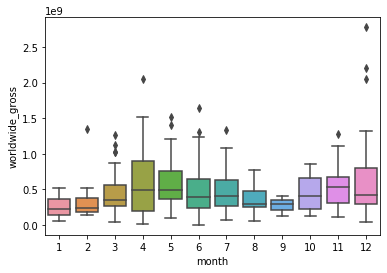

In [115]:
sns.boxplot(x= seasonlity_analysis['month'], y= seasonlity_analysis['worldwide_gross'], data=seasonlity_analysis)

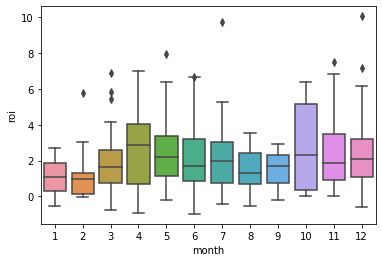

In [116]:
sns.boxplot(x= seasonlity_analysis['month'], y= seasonlity_analysis['roi'], data=seasonlity_analysis)


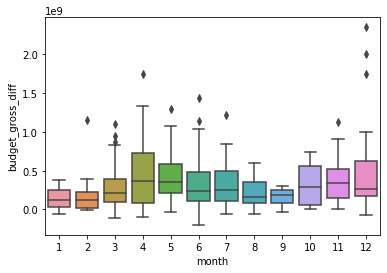

In [117]:
sns.boxplot(x= seasonlity_analysis['month'], y= seasonlity_analysis['budget_gross_diff'], data=seasonlity_analysis)

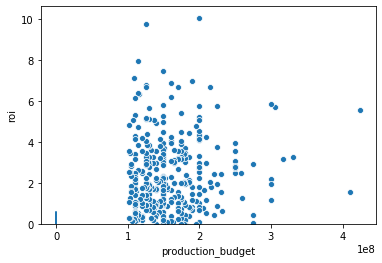

In [118]:
sns.scatterplot(x = movie_budgets_outliers['production_budget'], y= movie_budgets_outliers['roi']);
sorted_list = movie_budgets_outliers.sort_values(by= ['roi'] , ascending=False)

x = pd.Series(np.random.normal(size= 5782)) # 200 values
x = x[x.between(x.quantile(.15), x.quantile(.85))]

sns.distplot(x);


In [119]:
movie_budgets_clean

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696
...,...,...,...,...,...,...,...,...
5229,76,"May 26, 2006",Cavite,7000,70071,71644,64644,9.234857
5230,77,"Dec 31, 2004",The Mongol King,7000,900,900,-6100,-0.871429
5231,79,"Apr 2, 1999",Following,6000,48482,240495,234495,39.082500
5232,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,-0.732400


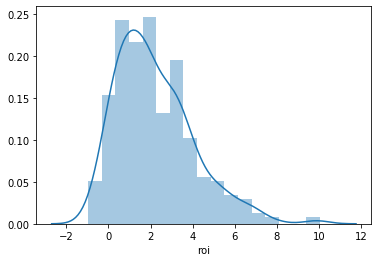

In [120]:
x = np.random.normal(size=100)
sns.distplot(movie_budgets_outliers['roi'])

In [121]:
extfranchises_clean = pd.read_csv('extfranchises_clean.csv')

In [122]:
extfranchises_clean

,Unnamed: 0,Franchise,#movies,domesticboxoffice,infl_adj_box_office,worldwideboxoffice,firstyear,last year,#years
0,0,Marvel Cinematic Universe,31,8545426433,9102945801,22576311289,2008,2022,14
1,1,Star Wars,15,5079119579,8039797255,10323355075,1977,2026,49
2,2,Harry Potter,12,2786938291,3638704111,9195390708,2001,2021,20
3,3,Batman,22,2786778902,3949355696,6049670921,1989,2021,32
4,4,Spider-Man,11,2711115724,3292639145,7219770479,2002,2019,17
...,...,...,...,...,...,...,...,...,...
673,673,Django,2,19391,22137,19391,1966,2020,54
674,674,St. Trinian's,2,15000,18220,29830239,2009,2009,
675,675,The Wedding Party,2,11140,11140,73115,2017,2017,
676,676,Donald Strachey,2,4269,5402,4269,2008,2008,


In [123]:
extfranchises_clean['ave_box_office'] = extfranchises_clean['worldwideboxoffice'] / extfranchises_clean['#movies']

In [124]:
extfranchises_clean

,Unnamed: 0,Franchise,#movies,domesticboxoffice,infl_adj_box_office,worldwideboxoffice,firstyear,last year,#years,ave_box_office
0,0,Marvel Cinematic Universe,31,8545426433,9102945801,22576311289,2008,2022,14,7.282681e+08
1,1,Star Wars,15,5079119579,8039797255,10323355075,1977,2026,49,6.882237e+08
2,2,Harry Potter,12,2786938291,3638704111,9195390708,2001,2021,20,7.662826e+08
3,3,Batman,22,2786778902,3949355696,6049670921,1989,2021,32,2.749850e+08
4,4,Spider-Man,11,2711115724,3292639145,7219770479,2002,2019,17,6.563428e+08
...,...,...,...,...,...,...,...,...,...,...
673,673,Django,2,19391,22137,19391,1966,2020,54,9.695500e+03
674,674,St. Trinian's,2,15000,18220,29830239,2009,2009,,1.491512e+07
675,675,The Wedding Party,2,11140,11140,73115,2017,2017,,3.655750e+04
676,676,Donald Strachey,2,4269,5402,4269,2008,2008,,2.134500e+03


In [125]:
extfranchises_clean.describe()

,Unnamed: 0,#movies,domesticboxoffice,infl_adj_box_office,worldwideboxoffice,firstyear,last year,ave_box_office
count,678.000000,678.000000,6.780000e+02,6.780000e+02,6.780000e+02,678.000000,678.000000,6.780000e+02
mean,338.500000,3.323009,2.154150e+08,3.388673e+08,5.129153e+08,1997.539823,2008.814159,1.254608e+08
std,195.866026,3.035064,5.128725e+08,6.889019e+08,1.351779e+09,14.608754,11.297938,1.873051e+08
min,0.000000,2.000000,3.328000e+03,3.726000e+03,4.269000e+03,1933.000000,1947.000000,2.134500e+03
25%,169.250000,2.000000,1.885954e+07,3.273766e+07,3.422396e+07,1988.000000,2004.000000,1.261163e+07
50%,338.500000,2.000000,7.860596e+07,1.422571e+08,1.409316e+08,2001.000000,2013.000000,5.128069e+07
75%,507.750000,3.000000,2.136546e+08,3.661053e+08,4.412118e+08,2009.000000,2017.000000,1.575624e+08
max,677.000000,39.000000,8.545426e+09,9.102946e+09,2.257631e+10,2020.000000,2027.000000,1.939340e+09


In [126]:
51280690+ (2*187305100)

425890890

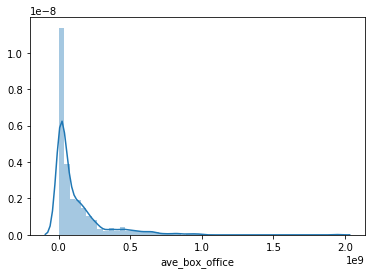

In [127]:
x = np.random.normal(size=100)
sns.distplot(extfranchises_clean['ave_box_office'])

In [128]:
extfranchises_clean_outliers = extfranchises_clean[extfranchises_clean['worldwideboxoffice'] < 1.409316e+08+(2*1.351779e+09)]

In [129]:
extfranchises_clean_outliers.describe()

,Unnamed: 0,#movies,domesticboxoffice,infl_adj_box_office,worldwideboxoffice,firstyear,last year,ave_box_office
count,656.000000,656.000000,6.560000e+02,6.560000e+02,6.560000e+02,656.000000,656.000000,6.560000e+02
mean,349.455793,3.064024,1.475675e+08,2.516606e+08,3.256211e+08,1997.480183,2008.460366,1.073421e+08
std,189.590916,2.311376,1.965082e+08,3.296833e+08,4.850689e+08,14.685806,11.302568,1.490942e+08
min,16.000000,2.000000,3.328000e+03,3.726000e+03,4.269000e+03,1933.000000,1947.000000,2.134500e+03
25%,185.750000,2.000000,1.762272e+07,2.916840e+07,3.224596e+07,1988.000000,2004.000000,1.217128e+07
50%,349.500000,2.000000,7.637369e+07,1.345984e+08,1.235354e+08,2001.000000,2013.000000,4.775044e+07
75%,513.250000,3.000000,1.968876e+08,3.383460e+08,3.933193e+08,2009.000000,2017.000000,1.468596e+08
max,677.000000,39.000000,1.400953e+09,2.594747e+09,2.788701e+09,2020.000000,2027.000000,9.807723e+08


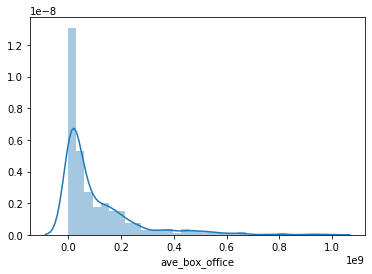

In [130]:
x = np.random.normal(size=100)
sns.distplot(extfranchises_clean_outliers['ave_box_office'])

In [131]:
movie_budgets_outliers.describe()

,id,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,roi
count,362.000000,3.620000e+02,3.620000e+02,3.620000e+02,3.620000e+02,362.000000
mean,47.157459,1.585251e+08,1.854952e+08,5.158472e+08,3.573221e+08,2.203751
std,28.163749,4.816200e+07,1.342903e+08,3.612874e+08,3.377526e+08,1.840434
min,1.000000,1.020000e+08,9.998110e+05,3.100000e+06,-2.002376e+08,-0.971818
25%,23.000000,1.250000e+08,9.355884e+07,2.692509e+08,1.250322e+08,0.856321
50%,46.000000,1.500000e+08,1.502799e+08,4.137134e+08,2.689052e+08,1.825943
75%,70.000000,1.787500e+08,2.346689e+08,6.857454e+08,5.386168e+08,3.242513
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2.351345e+09,10.041042


In [132]:
1.235354e+08 - 4.137134e+08

-290178000.0